### Delmål 1: Data Exploration & Preprocessing (Uge 1)
**Status:** ⬜ Ikke startet

**Opgaver:**
- [ ] Download MovieLens dataset
- [ ] Exploratory Data Analysis (EDA) i Jupyter notebook
- [ ] Forstå data struktur: users, movies, ratings, timestamps
- [ ] Håndter missing values og outliers
- [ ] Train/validation/test split (70/15/15)
- [ ] Baseline statistik (gennemsnitlig rating, populære film)

**Færdig når:** EDA notebook er komplet med visualiseringer og data er splittet korrekt.


In [192]:
# Packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

## 1. Basic Dataset Overview

**Mål:** Få et overblik over, hvad datasættet indeholder

- Antal rækker i:
  - `ratings`
  - `users` (hvis separat fil)
  - `movies`
- Antal unikke:
  - brugere (`n_users`)
  - film (`n_movies`)
- Sparsity:
  - Formel: $\text{sparsity} = 1 - \frac{\text{antal ratings}}{\text{antal users} \cdot \text{antal movies}}$
- Rating-skala:
  - Minimum, maksimum, gennemsnit, median
  - Tjek om ratings er i trin af 0.5 (fx 0.5, 1.0, 1.5, …)

**Visualiseringer:**

- Histogram af alle ratings
- Lille tabel med:
  - `n_users`, `n_movies`, `n_ratings`, `sparsity`, mean/median rating

---

In [193]:
# Load the data 
ratings = pd.read_csv("data/ratings.csv")
movies = pd.read_csv("data/movies.csv")

In [194]:
# Clean movies 
movies["publication_year"] = movies["title"].str.extract(r"\((\d{4})\)\s*$")
movies["title"] = movies["title"].str.replace(r"\s*\(\d{4}\)\s*$", "", regex=True)
display(movies)

,movieId,title,genres,publication_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [195]:
# Antal unikke users og movies 
num_users = len(ratings["userId"].unique())
num_movies = len(ratings["movieId"].unique())
num_ratings = len(ratings["rating"]) 

print("Number of unique users:", num_users)
print("Number of unique movies:", num_movies)

# Sparsity (hvor stor en andel af alle mulige bruger–film-kombinationer, der ikke har en rating)
sparsity = 1 - (num_ratings / (num_users * num_movies))
print(f"The sparsity of the user-movie combinations is: {sparsity:.2f}" )

# ratings min, max, mean, median, steps 
rating_max = ratings["rating"].max()
rating_min = ratings["rating"].min()
rating_mean = ratings["rating"].mean()
rating_median = ratings["rating"].median()
rating_steps = np.sort(ratings["rating"].astype(float).unique())
print(f"Rating max: {rating_max}")
print(f"Rating min: {rating_min}")
print(f"Rating mean: {rating_mean}")
print(f"Rating median: {rating_median}")
print(f"ratings steps: {rating_steps}")

Number of unique users: 610
Number of unique movies: 9724
The sparsity of the user-movie combinations is: 0.98
Rating max: 5.0
Rating min: 0.5
Rating mean: 3.501556983616962
Rating median: 3.5
ratings steps: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


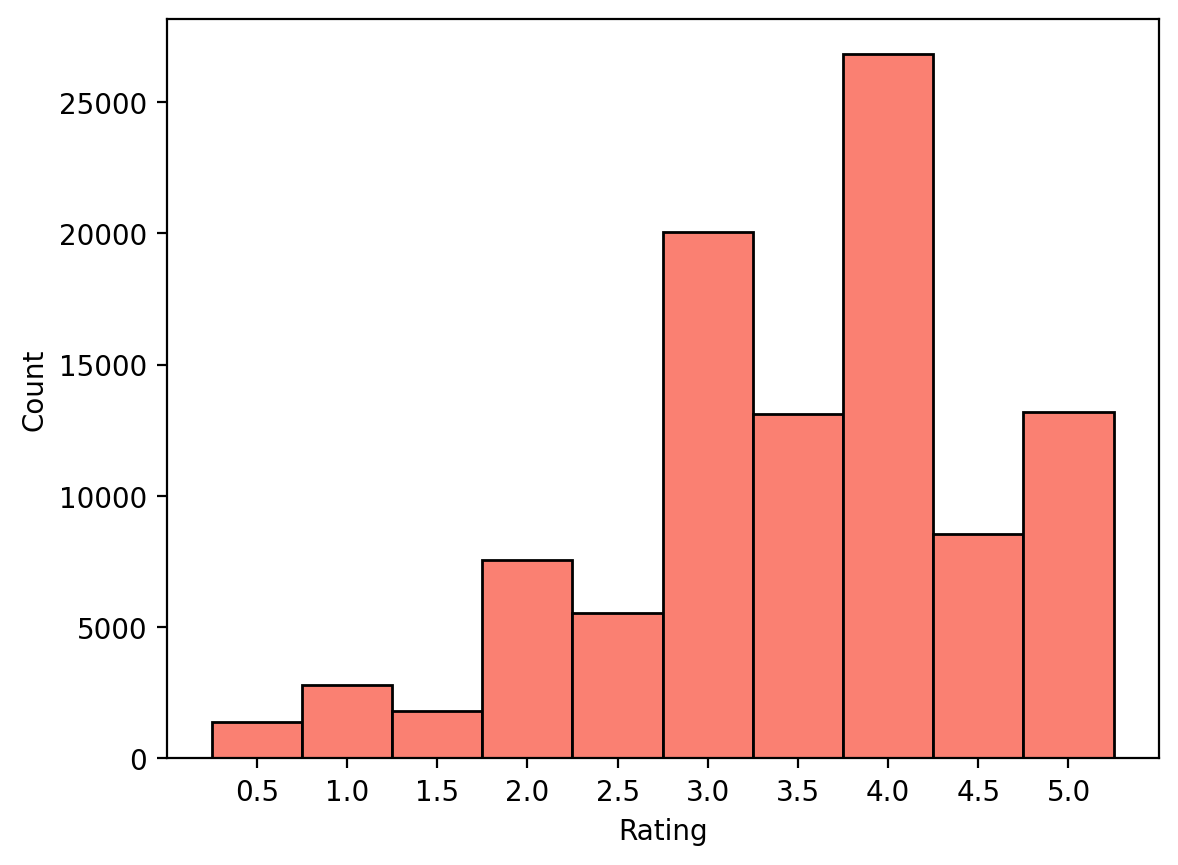

In [196]:
# Histogram of ratings 
bin_edges = np.append(rating_steps - 0.25, rating_steps[-1] + 0.25)
plt.hist(ratings["rating"], bins=bin_edges, color="salmon", edgecolor="black")
plt.xticks(rating_steps)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## 2. User Behavior

**Mål:** Forstå hvor aktive brugerne er, og hvor mange “svage” brugere der findes (cold-start)

**Per bruger (user):**

- Antal ratings per bruger: `n_ratings_user`
- Gennemsnitlig rating per bruger: `mean_rating_user`
- Evt. standardafvigelse: `std_rating_user`

**Analyser:**

- Histogram af `n_ratings_user`
  - Andel brugere med:
    - mindre end 5 ratings
    - mindre end 10 ratings
- Histogram af `mean_rating_user`
  - Er der mange meget positive/negative brugere?
- Evt. tabel:
  - Gennemsnitligt antal ratings per bruger
  - Median antal ratings per bruger

**Spørgsmål at besvare i teksten:**

- Hvor mange brugere har så få ratings, at de er svære at modellere?
- Overvejer du at filtrere brugere med meget få ratings fra i CF-modellen?

---

In [197]:
# count, mean and std of the user ratings
n_ratings_user = ratings.groupby("userId")["rating"].count()
mean_ratings_user = ratings.groupby("userId")["rating"].mean()
std_ratings_user = ratings.groupby("userId")["rating"].std()

# Users with too low number of ratings
users_lt5 = n_ratings_user[n_ratings_user < 5].index
users_lt10 = n_ratings_user[n_ratings_user < 10].index
print(users_lt5)
print(users_lt10)


# Remove very mean and very positiv users 
mean_lt2 = mean_ratings_user[mean_ratings_user < 2].index
ratings = ratings[~ratings["userId"].isin(mean_lt2)]

Index([], dtype='int64', name='userId')
Index([], dtype='int64', name='userId')


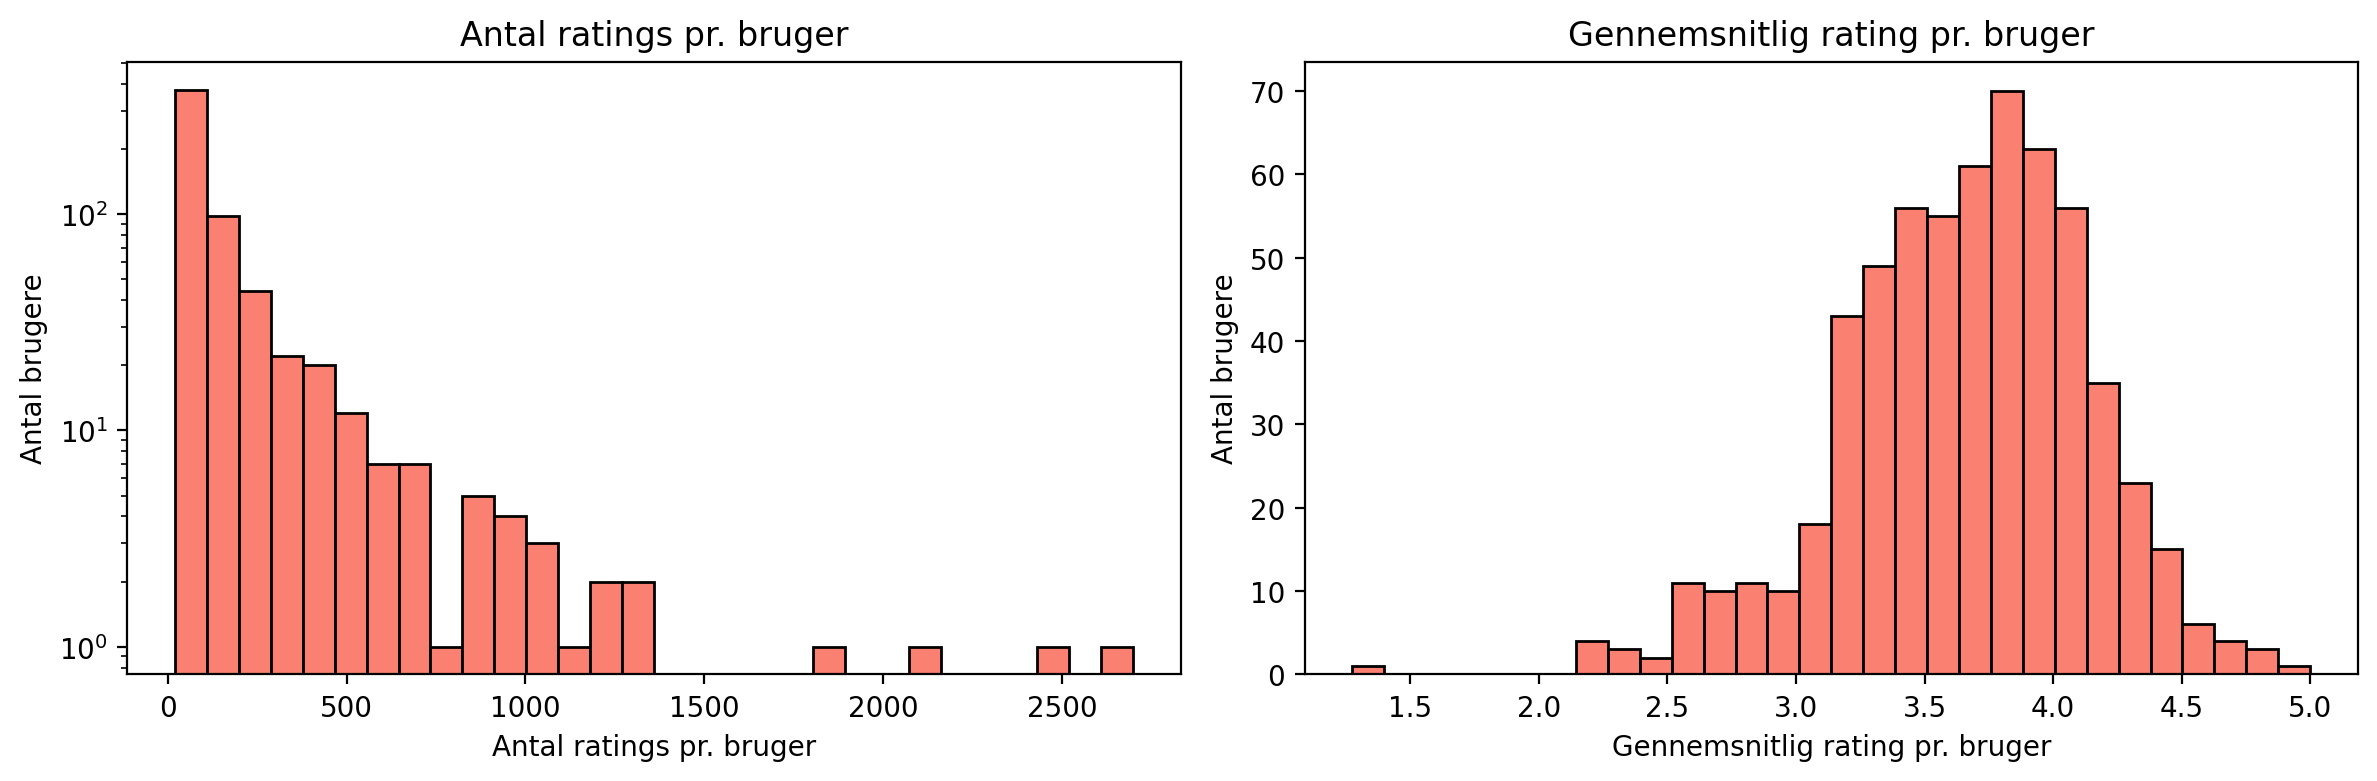

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: histogram of number of ratings per user
axes[0].hist(n_ratings_user, bins=30, edgecolor="black", color="salmon")
axes[0].set_yscale("log")
axes[0].set_xlabel("Antal ratings pr. bruger")
axes[0].set_ylabel("Antal brugere")
axes[0].set_title("Antal ratings pr. bruger")

# Right: histogram of mean rating per user
axes[1].hist(mean_ratings_user, bins=30, edgecolor="black", color="salmon")
axes[1].set_xlabel("Gennemsnitlig rating pr. bruger")
axes[1].set_ylabel("Antal brugere")
axes[1].set_title("Gennemsnitlig rating pr. bruger")

plt.tight_layout()
plt.show()


## 3. Movie / Item Behavior

**Mål:** Forstå popularitet og “long tail” af film

**Per film (item):**

- Antal ratings per film: `n_ratings_item`
- Gennemsnitlig rating per film: `mean_rating_item`
- Evt. standardafvigelse: `std_rating_item`

**Analyser:**

- Histogram af `n_ratings_item`
  - Vis fordeling (mange film med få ratings, få film med mange ratings)
- Top-lister:
  - Top-10 film med flest ratings
  - Top-10 bedst ratede film med en minimumsgrænse (fx mindst 50 ratings)
- Scatter plot-idé:
  - `n_ratings_item` på x-aksen
  - `mean_rating_item` på y-aksen
  - Tolkning: film med få ratings har ofte ekstreme gennemsnit

**Spørgsmål at besvare i teksten:**

- Hvor “lang” er long tail’en af film?
- Skal du kræve et minimum antal ratings per film for at bruge den i nogle modeller?

---

In [ ]:
# count, mean and std of the movie ratings 
n_ratings_movies = ratings.groupby("movieId")["rating"].count()
mean_ratings_movies = ratings.groupby("movieId")["rating"].mean()
std_ratings_movies = ratings.groupby("movieId")["rating"].std()

movie_stas = pd.concat(
    [
    n_ratings_movies.rename("n_ratings"),
    mean_ratings_movies.rename("mean_ratings"), 
    ], 
    axis=1,
)
# Top 10 most rated movies and top 10 best ratede movies 
movies_with_counts = (
    movies[["movieId", "title"]]
    .merge(movie_stas , on="movieId", how="left")
)
movies_50plus_ratings = movies_with_counts[movies_with_counts["n_ratings"] > 50]

# top 10 mest ratede film
movies_top10_most_rated = movies_with_counts.sort_values(by="n_ratings", ascending=False).head(10)
movies_top10_best_rated = movies_50plus_ratings.sort_values(by="mean_ratings", ascending=False).head(10)
display(movies_top10_most_rated)
display(movies_top10_best_rated)


,movieId,title,n_ratings,mean_ratings
314,356,Forrest Gump,329.0,4.164134
277,318,"Shawshank Redemption, The",317.0,4.429022
257,296,Pulp Fiction,307.0,4.197068
510,593,"Silence of the Lambs, The",279.0,4.161290
1939,2571,"Matrix, The",278.0,4.192446
224,260,Star Wars: Episode IV - A New Hope,251.0,4.231076
418,480,Jurassic Park,238.0,3.750000
97,110,Braveheart,237.0,4.031646
507,589,Terminator 2: Judgment Day,224.0,3.970982
461,527,Schindler's List,220.0,4.225000


,movieId,title,n_ratings,mean_ratings
277,318,"Shawshank Redemption, The",317.0,4.429022
659,858,"Godfather, The",192.0,4.289062
2226,2959,Fight Club,218.0,4.272936
975,1276,Cool Hand Luke,57.0,4.271930
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,97.0,4.268041
686,904,Rear Window,84.0,4.261905
922,1221,"Godfather: Part II, The",129.0,4.259690
6315,48516,"Departed, The",107.0,4.252336
914,1213,Goodfellas,126.0,4.250000
694,912,Casablanca,100.0,4.240000


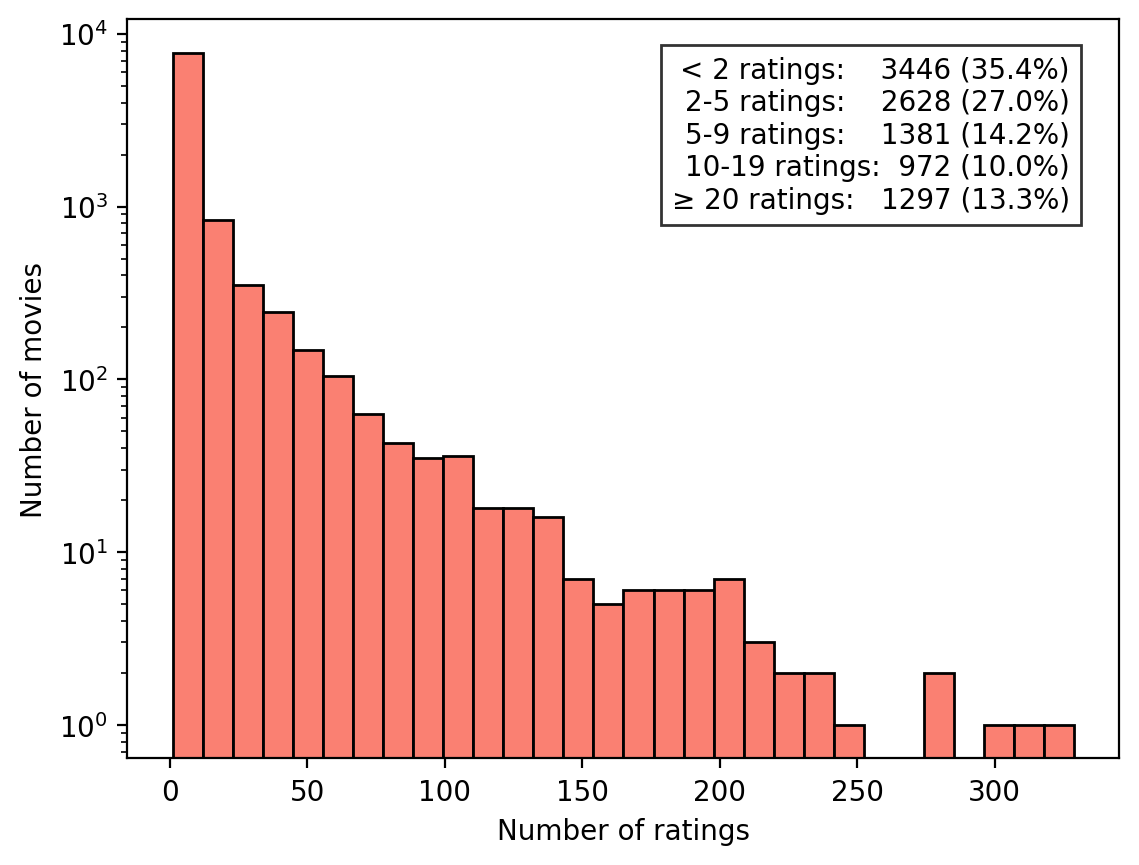

In [212]:
# Calculation to show how big a part that is < 5, < 10, < 20 
total_ratings_movies = len(movies_with_counts)

lt2 = movies_with_counts["n_ratings"] < 2
lt5   = (movies_with_counts["n_ratings"] >= 2) & (movies_with_counts["n_ratings"] < 5)
btw5_10  = (movies_with_counts["n_ratings"] >= 5) & (movies_with_counts["n_ratings"] < 10)
btw10_20 = (movies_with_counts["n_ratings"] >= 10) & (movies_with_counts["n_ratings"] < 20)
ge20  = movies_with_counts["n_ratings"] >= 20

n_lt2      = lt2.sum()
n_lt5      = lt5.sum()
n_5_10     = btw5_10.sum()
n_10_20    = btw10_20.sum()
n_ge20     = ge20.sum()

p_lt2      = n_lt2   / total_ratings_movies * 100
p_lt5      = n_lt5   / total_ratings_movies * 100
p_5_10     = n_5_10  / total_ratings_movies * 100
p_10_20    = n_10_20 / total_ratings_movies * 100
p_ge20     = n_ge20  / total_ratings_movies * 100

# The plot 
plt.hist(n_ratings_movies, edgecolor="black", color="salmon", bins=30)
plt.xlabel("Number of ratings")
plt.yscale("log")
plt.ylabel("Number of movies")

textstr = (
    f"< 2 ratings:    {n_lt2} ({p_lt2:.1f}%)\n"
    f"2-5 ratings:    {n_lt5} ({p_lt5:.1f}%)\n"
    f"5-9 ratings:    {n_5_10} ({p_5_10:.1f}%)\n"
    f"10-19 ratings:  {n_10_20} ({p_10_20:.1f}%)\n"
    f"≥ 20 ratings:   {n_ge20} ({p_ge20:.1f}%)"
)

ax = plt.gca()
ax.text(
    0.95, 0.95, textstr,
    transform=ax.transAxes,
    ha="right", va="top",
    bbox=dict(facecolor="white", alpha=0.8),
)

plt.show()


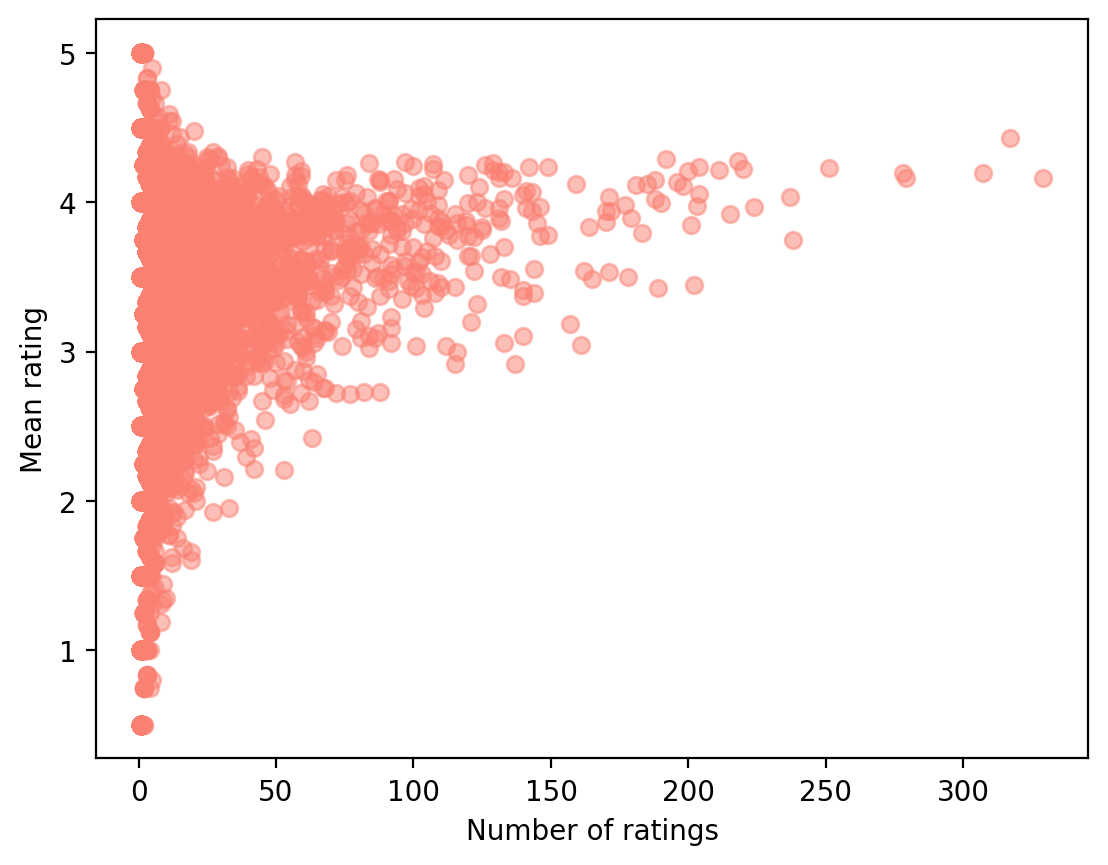

In [209]:
# Scatterplot 
plt.scatter(n_ratings_movies, mean_ratings_movies, color="salmon", alpha=0.5)
plt.ylabel("Mean rating")
plt.xlabel("Number of ratings")
plt.show()

## 5. Content / Metadata til Content-Based Filtering

**Mål:** Forstå hvilke features du har til content-based delen

**Fra film-metadata (fx `movies.csv`):**

- Titler:
  - Er formatet fx `"Toy Story (1995)"`?
- År:
  - Ekstrahér udgivelsesår fra titel eller separat kolonne
  - Histogram over film per år
  - Evt. gruppering per årti
- Genrer:
  - Liste over alle unikke genrer (split af `genres`-kolonnen)
  - Antal film per genre
  - Antal genrer per film (fordeling)
- Evt. andre features:
  - Tags / beskrivelser (hvis tilgængelige)
  - Kan senere bruges til TF-IDF

**Analyser:**

- Top-10 mest almindelige genrer
- Tabel over:
  - antal film uden år
  - antal film uden genre eller med `"no genres listed"`
- Fordeling af år for:
  - populære film (mange ratings)
  - mindre populære film (få ratings)

---